In [7]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("../../../")

from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from xgboost import XGBClassifier

from helpers.split import label_strings, tag_label_feature_split

In [8]:
def cross_gradient_boost_experiment(dataset):

    # load data and separate one hot encoded labels from features,
    # transform one hot encoded labels into label strings,
    # then encode label strings

    df = pd.read_pickle(dataset)
    _, one_hot_labels, X = tag_label_feature_split(df)
    labels = label_strings(one_hot_labels)

    le = LabelEncoder()
    y = le.fit_transform(pd.Series.ravel(labels))

    # divide into train and test data sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=10, stratify=y
    )

    # standardize features
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)

    model = XGBClassifier(use_label_encoder=False)

    model.fit(X_train_std, y_train)

    predictions = model.predict(X_test_std)
    train_accuracy = model.score(X_train_std, y_train)
    test_accuracy = model.score(X_test_std, y_test)

    class_names = le.inverse_transform(list(model.classes_))
    print(f"Train: {train_accuracy = :f}\n")
    print(
        classification_report(
            y_train, model.predict(X_train_std), digits=4, target_names=class_names
        )
    )
    print(f"Test: {test_accuracy = :f}\n")
    print(
        classification_report(y_test, predictions, digits=4, target_names=class_names)
    )

    # generate confusion matrix and
    # display nicely with seaborn
    cm = confusion_matrix(y_test, predictions, normalize="true")
    heatmap_labels = list(le.classes_)
    plt.figure(figsize=(9, 9))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".3f",
        linewidths=0.5,
        square=True,
        cmap="Blues_r",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    name = os.path.basename(dataset).split(".")[0]
    plt.title(f"{name} test (row normalized)")

    return model

[06:29:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train: train_accuracy = 0.913173

                 precision    recall  f1-score   support

    genre_blues     1.0000    0.8636    0.9268       374
genre_classical     0.9494    0.9647    0.9570      4221
  genre_country     1.0000    0.9633    0.9813       327
    genre_disco     1.0000    0.9516    0.9752       289
   genre_hiphop     0.9492    0.8783    0.9124      1701
     genre_jazz     0.9589    0.8276    0.8884      1241
    genre_metal     0.9922    0.9564    0.9740       665
      genre_pop     0.8264    0.9202    0.8708      4274
   genre_reggae     0.9782    0.9099    0.9428       788
     genre_rock     0.9048    0.8766    0.8905      3200

       accuracy                         0.9132     17080
      macro avg     0.9559 

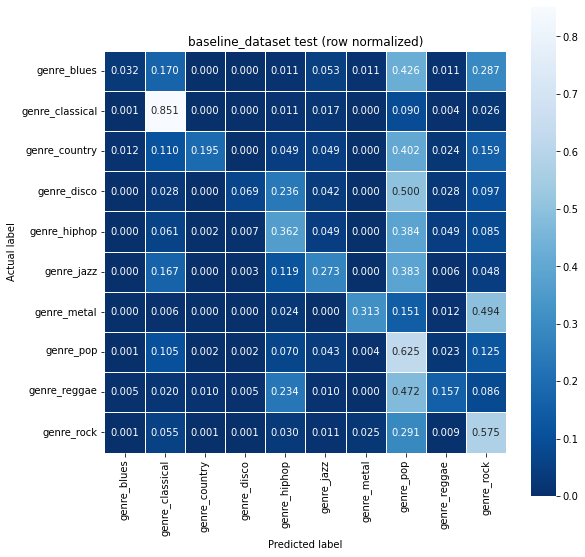

In [9]:
model_1 = cross_gradient_boost_experiment("../../../datasets/baseline_dataset.pickle")

[06:30:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train: train_accuracy = 0.999473

                 precision    recall  f1-score   support

    genre_blues     0.9973    1.0000    0.9987       374
genre_classical     0.9993    1.0000    0.9996      4221
  genre_country     1.0000    1.0000    1.0000       327
    genre_disco     1.0000    1.0000    1.0000       289
   genre_hiphop     0.9988    1.0000    0.9994      1701
     genre_jazz     1.0000    0.9992    0.9996      1241
    genre_metal     1.0000    1.0000    1.0000       665
      genre_pop     0.9993    0.9991    0.9992      4274
   genre_reggae     1.0000    1.0000    1.0000       788
     genre_rock     1.0000    0.9988    0.9994      3200

       accuracy                         0.9995     17080
      macro avg     0.9995 

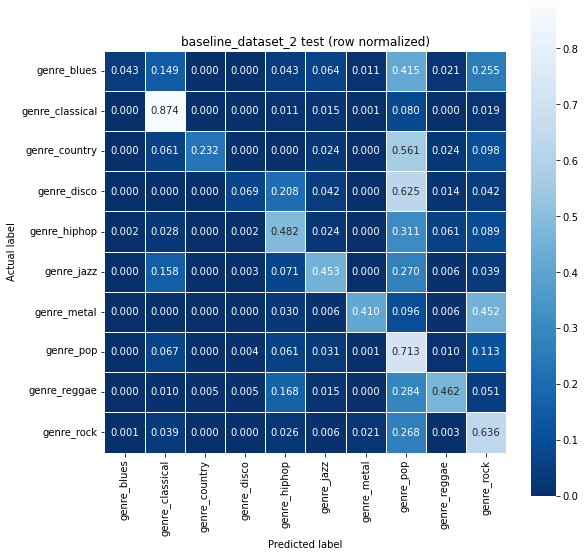

In [10]:
model_2 = cross_gradient_boost_experiment("../../../datasets/baseline_dataset_2.pickle")

Train: train_accuracy = 1.000000

                 precision    recall  f1-score   support

    genre_blues     1.0000    1.0000    1.0000       374
genre_classical     1.0000    1.0000    1.0000      4221
  genre_country     1.0000    1.0000    1.0000       327
    genre_disco     1.0000    1.0000    1.0000       289
   genre_hiphop     1.0000    1.0000    1.0000      1701
     genre_jazz     1.0000    1.0000    1.0000      1241
    genre_metal     1.0000    1.0000    1.0000       665
      genre_pop     1.0000    1.0000    1.0000      4274
   genre_reggae     1.0000    1.0000    1.0000       788
     genre_rock     1.0000    1.0000    1.0000      3200

       accuracy                         1.0000     17080
      macro avg     1.0000    1.0000    1.0000     17080
   weighted avg     1.0000    1.0000    1.0000     17080

Test: test_accuracy = 0.558886

                 precision    recall  f1-score   support

    genre_blues     0.6000    0.0319    0.0606        94
genre_classical   

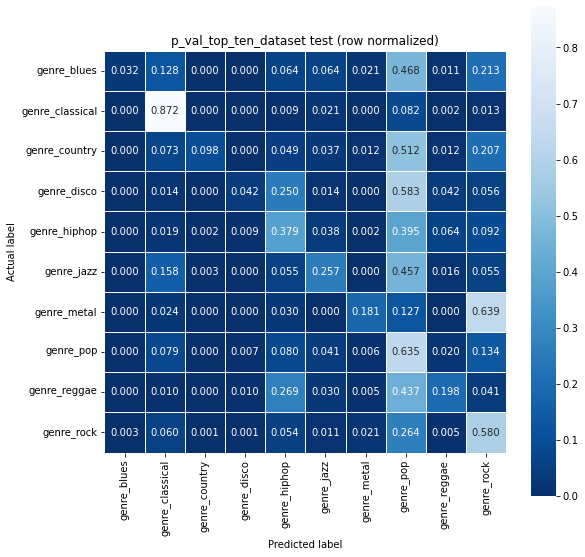

In [5]:
model_3 = cross_gradient_boost_experiment("../../../datasets/p_val_top_ten_dataset.pickle")